# Exercício - Difração

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from IPython.display import display, display_html, HTML

from examples.seismic import Model, plot_velocity, TimeAxis, setup_geometry, RickerSource, AcquisitionGeometry
from devito import *

import gc
%matplotlib inline

mpi4py is not available. You must install it


## Parâmetros dos operadores de diferenças finitas

In [2]:
space_order=2

## Definição do modelo

### Dimensões do modelo

O modelo possui dimensões $w \times h = 1000 \mathrm{m} \times 1000 \mathrm{m}$, e um espaçamento de $\Delta x = \Delta z = 10$ m. Logo, a malha deverá ter 
$$
n_x = \frac{w}{\Delta x} + 1 = \frac{1000 \mathrm{m}}{10 \mathrm{m}} + 1 = 101
$$
pontos ao longo do eixo x, e
$$
n_z = \frac{h}{\Delta z} + 1 = \frac{1000 \mathrm{m}}{10 \mathrm{m}} + 1 = 101
$$
pontos ao longo do eixo z.

In [3]:
shape = (101, 101)
spacing = (10., 10.)
origin = (0., 0.)
# nbl=325
nbl=100

### Parâmetros físicos

In [4]:
vp1 = 1.5 # Velocidade da primeira camada
vp2 = 3.0 # Velocidade da segunda camada
v = vp1 * np.ones(shape, dtype=np.float32)
v[
    shape[0]//2 - 2:shape[0]//2 + 2, 
    shape[1]//2 - 2:shape[1]//2 + 2
] = vp2
v[
    shape[0]//4 - 2:shape[0]//4 + 2, 
    shape[1]//2 - 2:shape[1]//2 + 2
] = vp2
v[
    3*shape[0]//4 - 2:3*shape[0]//4 + 2, 
    shape[1]//2 - 2:shape[1]//2 + 2
] = vp2


In [5]:
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=space_order, nbl=nbl, bcs="damp")

Operator `initdamp` ran in 0.01 s


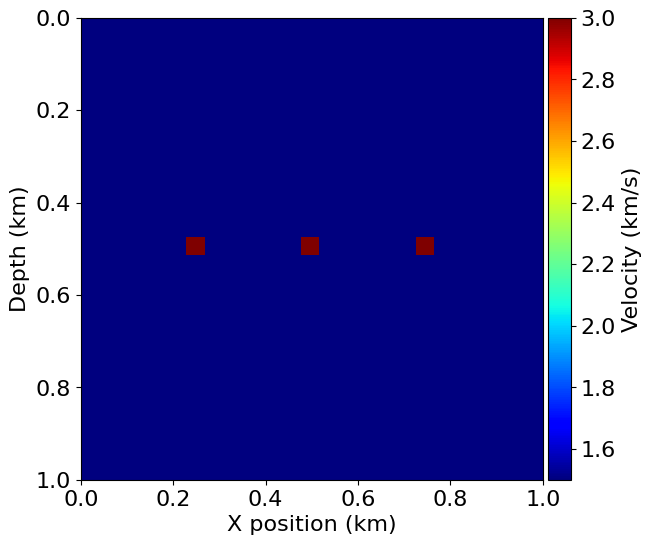

In [6]:
plot_velocity(model)

## Parâmetros da aquisição

### Tempo de aquisição

In [7]:
t0 = 0.  # ms
tn = 1000. # ms
dt = model.critical_dt

time_range = TimeAxis(start=t0, stop=tn, step=dt)

### Geometria

Como o valor mínimo do campo de velocidade é $1.5\ \mathrm{km/s}$, o espaçamento do modelo é $\Delta x = \Delta z = 10 \mathrm{m}$ e a ordem do operador de diferenças finitas para as derivadas espaciais é igual a $2$ (F = 10), a frequência máxima $f_{\mathrm{max}}$ da onda propagada deve satisfazer
$$
\begin{aligned}
f_{\mathrm{max}} &\le \frac{\min{v_P}}{F\max{\Delta x, \Delta z}}\\
    &= \frac{1.5\ \mathrm{km/s}}{10 \times 10\ \mathrm{m}}\\
    &= 0.015\ \mathrm{kHz}
\end{aligned}
$$
A assinatura da fonte será a fonte de Ricker, que possui uma frequência de pico $f_{\mathrm{peak}} \approx = \dfrac{1}{3} f_{\mathrm{max}}$. Com base nisto, foi escolhida uma frequência máxima de $0.015\ \mathrm{kHz}$, resultando numa frequência de pico igual a $0.005\ \mathrm{kHz}$.

In [8]:
# Frequência de pico da fonte
f0 = 0.005

In [9]:
geometry = AcquisitionGeometry(model, np.array([[0,0]], dtype=model.dtype), np.array([[0,0]], dtype=model.dtype), t0, tn)
# geometry.resample(dt)

In [10]:
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, 0] = model.domain_size[0] * .5
src.coordinates.data[0, 1] = model.domain_size[1]* .25

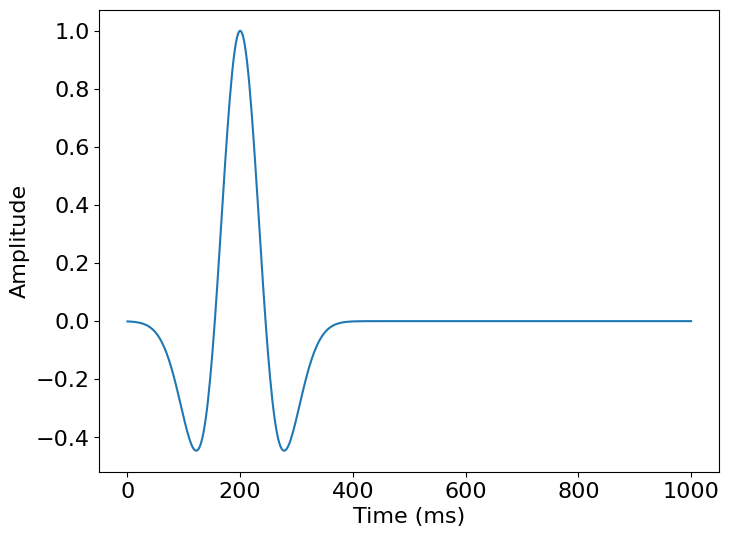

In [11]:
src.show()

#### Posição da fonte

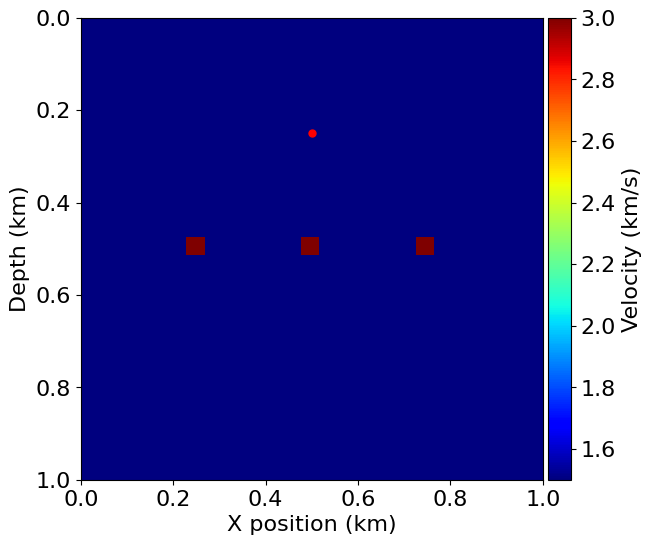

In [12]:
plot_velocity(model, source=src.coordinates.data)

## Resolução da alternativa a)

### Definição da equação da onda acústica de 2ª ordem

Aqui é definida no *Devito* a equação

$$
\frac{1}{v_P^2}\frac{\partial^2 P}{\partial t^2} - \rho \nabla \cdot \left( \frac{1}{\rho} \nabla P \right) = S
$$

em que:

- $P$ é o campo de pressão;
- $v_P$ é o campo de velocidade da onda P;
- $\rho$ é o campo de densidade;
- $S$ é o termo fonte;

In [13]:
# Função pra o campo de pressão
P = TimeFunction(name="P", grid=model.grid, time_order=2, space_order=space_order, save=geometry.nt, staggered=NODE)

In [14]:
vp = model.vp

In [15]:
# Equação da onda acústica de 2ª ordem
EDP = 1/vp**2 * P.dt2 - P.laplace
EDP

-Derivative(P(time, x, y), (x, 2)) - Derivative(P(time, x, y), (y, 2)) + Derivative(P(time, x, y), (time, 2))/vp(x, y)**2

In [16]:
# Expressão para o campo de ondas futuro, P(r, t + dt)
stencil = Eq(P.forward, solve(EDP, P.forward))
stencil

Eq(P(time + dt, x, y), dt**2*(-(-2.0*P(time, x, y)/dt**2 + P(time - dt, x, y)/dt**2)/vp(x, y)**2 + Derivative(P(time, x, y), (x, 2)) + Derivative(P(time, x, y), (y, 2)))*vp(x, y)**2)

Com base na expressão acima para o campo $P(\mathbf{x}, t + \Delta t)$, observa-se que o termo fonte possui um coeficiente igual a $\Delta t^2 v_P^2$. Logo, a fonte $S$ deve ser injetada no campo de ondas futuro como $\Delta t^2 v_P^2 S(\mathbf{x}, t) = \Delta t^2 v_P^2 s(t)\delta(\mathbf{x} - \mathbf{x}_x)$

In [17]:
# Símbolo do espaçamento temporal
s = model.grid.stepping_dim.spacing

# Expressão do termo fonte a ser injetada no stencil criado acima
src_term = src.inject(field=P.forward, expr=src * s**2 * vp**2)

### Criação do operador de diferenças finitas

In [18]:
# Criação do operador do Devito
op = Operator([stencil] + src_term, subs=model.spacing_map)

In [19]:
# Execução
op(dt=dt)

Operator `Kernel` ran in 0.02 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.01692099999999999, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=2.600000000000001e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

### Plotagem do campo de ondas

In [20]:
def plot_wavefield(u, geometry, src_pos, model, title=None, reverse_time=False, t0=0, tn=-1, rec_pos=None):
    shape_pad = np.array(model.shape) + 2 * nbl
    origin_pad = tuple([o - s*nbl for o, s in zip(origin, spacing)])
    extent_pad = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])

    # Note: flip direction of second dimension to make the plot positive downwards
    plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
                origin_pad[1] + extent_pad[1], origin_pad[1]]
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharex=True)
    fig.suptitle(title, size=20, y=1.05)
    isfirst = True
    last_ax = None
    last_plot = None

    t0 = t0 - geometry.t0
    tn = tn - geometry.t0

    snapshots = None
    if tn < 0:
        idx_min = max(int(np.round(t0/dt)), 0)
        snapshots = np.linspace(idx_min, geometry.nt - 1, num=4, dtype=np.int32)
    else:
        idx_min = max(int(np.round(t0/dt)), 0)
        idx_max = min(int(np.round(tn/dt)), geometry.nt - 1)
        snapshots = np.linspace(idx_min, idx_max, num=4, dtype=np.int32)


    udata = u.data

    amax = np.max(np.abs(udata[geometry.nt-1, :, :]))
    if reverse_time:
        snapshots = np.flip(snapshots)
        amax = np.max(np.abs(udata[0, :, :]))


    for count, ax in enumerate(axes.ravel()):
        snapshot = snapshots[count]
        last_plot = ax.imshow(udata[snapshot,:,:].T,
                              cmap="seismic", vmin=-amax,
                  vmax=+amax, extent=plt_extent)
        ax.plot(src_pos[0], src_pos[1], 'red', linestyle='None', marker='*',
                markersize=8, label="Source")
        
        if type(rec_pos) != type(None):
            ax.plot(rec_pos[0], rec_pos[1], 'green', linestyle='None', marker='v',
                    markersize=8, label="Receiver")
            
        nbl_color = 'xkcd:dark blue'
        ax.plot([model.origin[0], model.domain_size[0]], [model.origin[1], model.origin[1]], ls='dashed', color=nbl_color)
        ax.plot([model.domain_size[0], model.domain_size[0]], [model.origin[1], model.domain_size[1]], ls='dashed', color=nbl_color)
        ax.plot([model.origin[0], model.domain_size[0]], [model.domain_size[1], model.domain_size[1]], ls='dashed', color=nbl_color)
        ax.plot([model.origin[0], model.origin[0]], [model.origin[1], model.domain_size[1]], ls='dashed', color=nbl_color)
        # ax.text(0, 0, 'nbl', color=nbl_color)

        ax.grid()
        ax.tick_params('both', length=4, width=0.5, which='major', labelsize=11)

        ax.set_title("t=%.2fms" % (snapshot*dt + geometry.t0), fontsize=12)
        ax.set_xlabel("x (m)", fontsize=12)
        isfirst and ax.set_ylabel("z (m)", fontsize=12)
        isfirst = False
        last_ax = ax
    
    divider = make_axes_locatable(last_ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(last_plot, cax=cax)

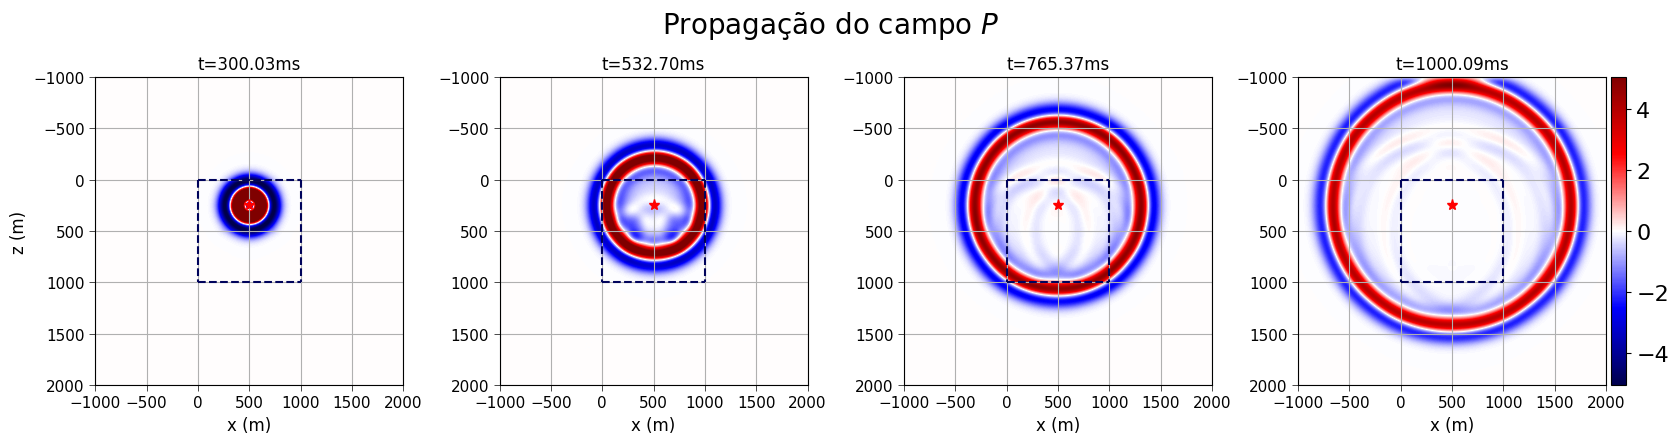

In [21]:
plot_wavefield(P, geometry, src.coordinates.data[0], model, 'Propagação do campo $P$', t0=300, tn=1600)

## Resolução da alternativa b)

In [22]:
def plot_animated_wavefield(u, geometry, src_pos, model, title=None, reverse_time=False, t0=0, tn=-1, rec_pos=None, nframes=10):
    shape_pad = np.array(model.shape) + 2 * nbl
    origin_pad = tuple([o - s*nbl for o, s in zip(origin, spacing)])
    extent_pad = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])

    # Note: flip direction of second dimension to make the plot positive downwards
    plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
                origin_pad[1] + extent_pad[1], origin_pad[1]]
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5), sharex=True)
    fig.suptitle(title, size=20, y=1.05)

    t0 = t0 - geometry.t0
    tn = tn - geometry.t0

    snapshots = None
    if tn < 0:
        idx_min = max(int(np.round(t0/dt)), 0)
        snapshots = np.linspace(idx_min, geometry.nt - 1, num=nframes, dtype=np.int32)
    else:
        idx_min = max(int(np.round(t0/dt)), 0)
        idx_max = min(int(np.round(tn/dt)), geometry.nt - 1)
        snapshots = np.linspace(idx_min, idx_max, num=nframes, dtype=np.int32)


    udata = u.data

    amax = np.max(np.abs(udata[geometry.nt-1, :, :]))
    if reverse_time:
        snapshots = np.flip(snapshots)
        amax = np.max(np.abs(udata[0, :, :]))
    
    snapshot = snapshots[0]
    wave_plot = ax.imshow(udata[snapshot,:,:].T,
                            cmap="seismic", vmin=-amax,
                vmax=+amax, extent=plt_extent)
    ax.plot(src_pos[0], src_pos[1], 'red', linestyle='None', marker='*',
            markersize=8, label="Source")
    
    if type(rec_pos) != type(None):
        ax.plot(rec_pos[0], rec_pos[1], 'green', linestyle='None', marker='v',
                markersize=8, label="Receiver")
        
    nbl_color = 'xkcd:dark blue'
    ax.plot([model.origin[0], model.domain_size[0]], [model.origin[1], model.origin[1]], ls='dashed', color=nbl_color)
    ax.plot([model.domain_size[0], model.domain_size[0]], [model.origin[1], model.domain_size[1]], ls='dashed', color=nbl_color)
    ax.plot([model.origin[0], model.domain_size[0]], [model.domain_size[1], model.domain_size[1]], ls='dashed', color=nbl_color)
    ax.plot([model.origin[0], model.origin[0]], [model.origin[1], model.domain_size[1]], ls='dashed', color=nbl_color)

    ax.grid()
    ax.tick_params('both', length=4, width=0.5, which='major', labelsize=11)

    ax.set_title("t=%.2fms" % (snapshot*dt + geometry.t0), fontsize=12)
    ax.set_xlabel("x (m)", fontsize=12)
    ax.set_ylabel("z (m)", fontsize=12)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(wave_plot, cax=cax)

    def update(snapshot):
        wave_plot.set_array(udata[snapshot,:,:].T)
        ax.set_title("t=%.2fms" % (snapshot*dt + geometry.t0), fontsize=12)

    anim = animation.FuncAnimation(fig, update, frames=snapshots, blit=False)

    plt.close(fig)
    display(HTML(anim.to_jshtml()))

In [23]:
plot_animated_wavefield(P, geometry, src.coordinates.data[0], model, 'Propagação do campo $P$', nframes=40)